In [26]:
%matplotlib inline

In [100]:
import pickle as pkl
import seaborn as sb
import matplotlib as mpl
import pandas as pd

from matplotlib import pyplot as plt
from graph_tool import load_graph, Graph, GraphView
from graph_tool.topology import kcore_decomposition
from graph_tool.draw import sfdp_layout, graph_draw

from graph_helpers import normalize_edges

In [2]:
graph_name = 'grqc'
g = load_graph('data/{}/graph.gt'.format(graph_name))

In [14]:
obj_before = sum(kcore_decomposition(g).a)

In [12]:
edges_dir = 'output/grqc/{}/B100.pkl'
greedy_edges = pkl.load(open(edges_dir.format('greedy'), 'rb'))
subcore_edges, subcore_log = pkl.load(open(edges_dir.format('subcore'), 'rb'))

In [48]:
subcore_edges = normalize_edges(subcore_edges)
greedy_edges = normalize_edges(greedy_edges)

In [18]:
greedy_g = g.copy()
subcore_g = g.copy()

In [19]:
greedy_g.add_edge_list(greedy_edges)
subcore_g.add_edge_list(subcore_edges)

In [22]:
obj_greedy = sum(kcore_decomposition(greedy_g).a)
obj_subcore = sum(kcore_decomposition(subcore_g).a)
print('obj before', obj_before)
print('obj greedy: {}, gain: {}'.format(obj_greedy, obj_greedy - obj_before))
print('obj subcore: {}, gain: {}'.format(obj_subcore, obj_subcore - obj_before))

obj before 19064
obj greedy: 19467, gain: 403
obj subcore: 19352, gain: 288


In [24]:
pos = sfdp_layout(g)

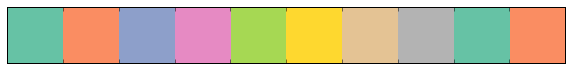

In [35]:
pal = sb.color_palette("Set2", 10)
sb.palplot(pal)

In [41]:
NODE_COLOR_INDEX = 5
EDGE_COLOR_DEFAULT = 7
EDGE_COLOR_ADDED = 9

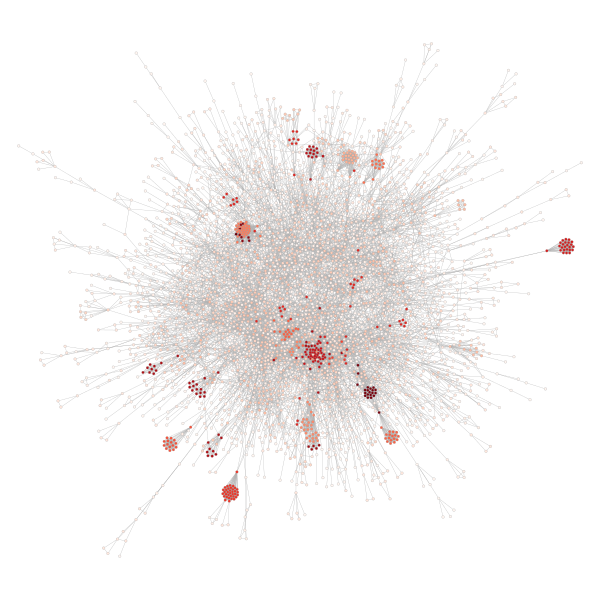

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f640d0026d8, at 0x7f640cf3dc88>

In [57]:
edge_color = g.new_edge_property('vector<float>')
for e in g.edges():
    edge_color[e] = pal[EDGE_COLOR_DEFAULT]

graph_draw(g, pos=pos,
           vertex_fill_color=kcore_decomposition(g),
           edge_color=edge_color,
           vcmap=mpl.cm.Reds)

In [130]:
def draw_added_edges(target_g, target_edges, output_path):
    node_color = target_g.new_vertex_property('int')
    node_color.a = kcore_decomposition(target_g).a - kcore_decomposition(g).a

    target_edges_set = set(target_edges)
    edge_color = target_g.new_edge_property('vector<float>')
    edge_pen_width = target_g.new_edge_property('float')
    eorder = target_g.new_edge_property('float')
    efilt = target_g.new_edge_property('bool')

    for e in target_g.edges():
        e_int = tuple(sorted(map(int, [e.source(), e.target()])))
        if e_int in target_edges_set:
            edge_color[e] = pal[EDGE_COLOR_ADDED]
            edge_pen_width[e] = 1
            eorder[e] = 1
            efilt[e] = True
        else:
            edge_color[e] = pal[EDGE_COLOR_DEFAULT]
            edge_pen_width[e] = 0.5
            eorder[e] = 0
            efilt[e] = False

    target_gv = GraphView(target_g, efilt=efilt)

    graph_draw(target_gv, pos=pos,
               vertex_fill_color=node_color,
               edge_pen_width=edge_pen_width,
               edge_color=edge_color,
               eorder=eorder,
               vcmap=mpl.cm.Reds,
               output=output_path)

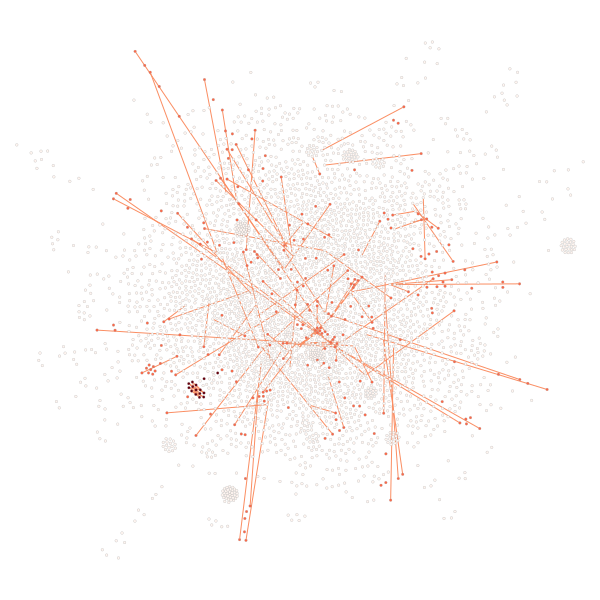

In [131]:
draw_added_edges(subcore_g, subcore_edges, 'figs/added_edges_viz/grqc/subcore.png')

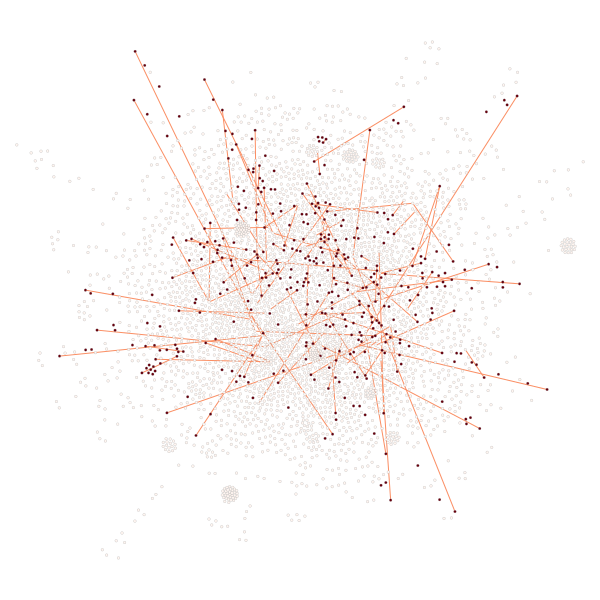

In [132]:
draw_added_edges(greedy_g, greedy_edges, 'figs/added_edges_viz/grqc/greedy.png')

In [93]:
greedy_diff = kcore_decomposition(greedy_g).a - kcore_decomposition(g).a
subcore_diff = kcore_decomposition(subcore_g).a - kcore_decomposition(g).a

greedy_diff = pd.Series(greedy_diff[greedy_diff>0])
subcore_diff = pd.Series(subcore_diff[subcore_diff>0])

In [94]:
greedy_diff.describe()

count    403.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
dtype: float64

In [95]:
subcore_diff.describe()

count    273.000000
mean       1.054945
std        0.228291
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
dtype: float64

In [109]:
greedy_g = g.copy()
kcore_sum_log_greedy = []
for e in greedy_edges:
    greedy_g.add_edge(*e)
    kcore_sum_log_greedy.append(sum(kcore_decomposition(greedy_g).a) - obj_before)

In [116]:
subcore_g = g.copy()
kcore_sum_log_subcore = []
for edges in subcore_log['edges_list']:
    subcore_g.add_edge_list(edges)
    inc = sum(kcore_decomposition(subcore_g).a) - obj_before
    kcore_sum_log_subcore += ([inc] * len(edges))

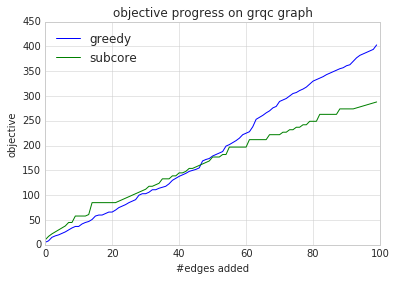

In [133]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(kcore_sum_log_greedy)
ax.plot(kcore_sum_log_subcore)
ax.legend(['greedy', 'subcore'], loc='best')
ax.set_xlabel('#edges added')
ax.set_ylabel('objective')
ax.set_title('objective progress on grqc graph')
fig.savefig('figs/obj_grow/grqc.png')

In [145]:
# inspect the subcore algorithm
subcore_g = g.copy()
core_before = kcore_decomposition(subcore_g).a
rows = []
for edges in subcore_log['edges_list']:
    subcore_g.add_edge_list(edges)
    core_after = kcore_decomposition(subcore_g).a
    sc = set((core_after - core_before).nonzero()[0])
    intra_sc_edges = set([(u, v) for u, v in edges if u in sc and v in sc])
    inter_sc_edges = set(edges) - intra_sc_edges
    row = (len(sc), len(intra_sc_edges), len(inter_sc_edges))
    rows.append(row)
    # print('|sc|={}, |sc-edges|={}, |other-edges|={}'.format(*row))
    core_before = core_after

df = pd.DataFrame(rows, columns=['#sc', '#subcore edges', '#inter-subcore edges'])
df

,#sc,#subcore edges,#inter-subcore edges
0,10,1,0
1,7,1,0
2,5,0,1
3,4,0,1
4,4,0,1
5,4,0,1
6,4,0,1
7,7,0,2
8,13,0,4
9,3,0,1
